In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from datetime import datetime
rcParams['figure.figsize'] = 15, 6

In [2]:
df = pd.read_csv("fact_price_weekly_multi.csv")

In [3]:
df.date_sk = df.date_sk.astype(str)

In [4]:
df["date_sk"] = df.date_sk.apply(lambda dates: datetime.strptime(dates, '%Y%m%d').strftime('%m/%d/%Y'))

In [5]:
df['date_sk'] = pd.to_datetime(df['date_sk'])


In [6]:
df = df.set_index("date_sk")
df.price = df.price.fillna(np.mean(df.price))

In [7]:
ts = df["price"]

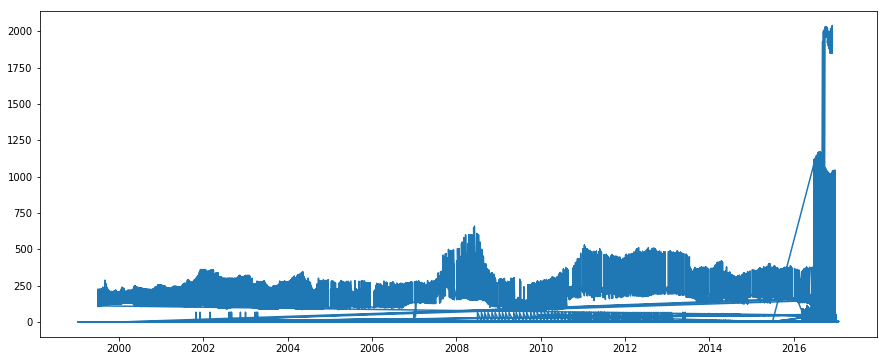

In [8]:
plt.plot(ts)


In [9]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


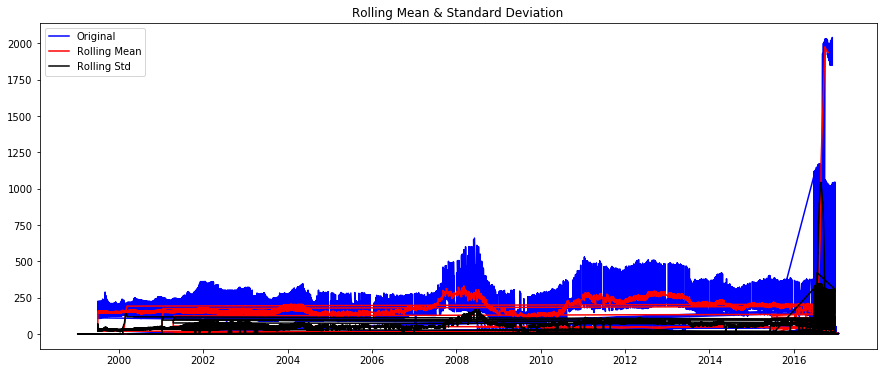

Results of Dickey-Fuller Test:
Test Statistic                    -2.728630
p-value                            0.069214
#Lags Used                        51.000000
Number of Observations Used    35008.000000
Critical Value (5%)               -2.861623
Critical Value (1%)               -3.430537
Critical Value (10%)              -2.566814
dtype: float64


In [10]:
test_stationarity(ts)

In [11]:
import statsmodels.api as sm
import math
import random
import pandas as pd
from scipy.stats import t
import scipy.stats as st
import numpy as np
import collections

from numbers import Number

In [110]:
import pandas as pd
import numpy as np
df = pd.read_csv("fact_price_weekly_multi.csv")

In [111]:
np.random.seed(0)

In [112]:
df["product"] = df["product"].astype('category').cat.codes
df["unit"] = df["unit"].astype('category').cat.codes
df["geo"] = df["geo"].astype('category').cat.codes

In [113]:
df.price = df.price.fillna(np.mean(df.price))
sd = np.std(df["price"])
mean = np.mean(df["price"])
X_upper = mean + sd*3
X_lower = mean - sd*3

In [114]:
rng = np.random.RandomState(42)

# Generate some abnormal novel observations
X_outliers_1 = rng.uniform(low=X_upper*0.85, high=X_upper*1.5, size=(50, 1))
X_outliers_2 = rng.uniform(low=-X_lower*1.5, high=-X_lower*0.85, size=(50, 1))

In [115]:
Outliers = []
Outliers.extend(X_outliers_1)
Outliers.extend(X_outliers_2)

In [116]:
df["Actual"] = False

In [117]:
idx = df.index
for i in Outliers:
    loc = np.random.randint(0, len(df))
    df.loc[loc,"price"] = i
    df.loc[loc,"Actual"] = True

In [869]:
#df[df.Actual==True]

In [870]:
# Randomly sample 70% of your dataframe
#X_train = df.sample(frac=0.7)

#X_test = df.loc[~df.index.isin(X_train.index)]

In [118]:
df = df.drop("id",axis=1)
df = df.drop("source",axis=1)

In [119]:
df[['Year']] = df[['date_sk']].applymap(str).applymap(lambda s: "{}".format(s[0:4]))
df[['Month']] = df[['date_sk']].applymap(str).applymap(lambda s: "{}".format(s[4:6]))
df[['Day']] = df[['date_sk']].applymap(str).applymap(lambda s: "{}".format(s[6:8]))

df.head()

,date_sk,geo,unit,product,price,Actual,Year,Month,Day
0,20161130,16,16,18,1850.0,False,2016,11,30
1,20161130,16,16,19,2040.0,False,2016,11,30
2,20161123,16,16,18,1850.0,False,2016,11,23
3,20161123,16,16,19,2020.0,False,2016,11,23
4,20161116,16,16,18,1850.0,False,2016,11,16


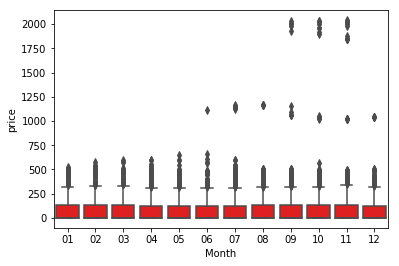

In [121]:
import seaborn as sns

ax = sns.boxplot(x="Month", y="price", data=df,color="red")
#ax = sns.swarmplot(x="Month", y="price", data=df_year, color=".25")

In [122]:
from sklearn import preprocessing
df = df.dropna()
df_new = df[["date_sk","geo","price","unit","product","Year","Month","Day"]]
#df_new = df["price"]
min_max_scaler = preprocessing.MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(df_new)
df_scaled = pd.DataFrame(df_scaled)
df_scaled = df_scaled.astype('float32')

In [123]:
len(df_scaled)

35060

In [124]:
array = np.array(df_scaled)
row,column = array.shape
array = array.reshape((1,row,column))

In [125]:
array.shape

(1, 35060, 8)

In [126]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = column  # 80 floats -> compression of factor 0.8, assuming the input is 100 floats

# this is our input placeholder
input = Input(shape=(row,column))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(column, activation='sigmoid')(encoded)
#rps an input to its reconstruction
autoencoder = Model(inputs=input, outputs=decoded)
encoder = Model(inputs=input, outputs=encoded)

In [127]:

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=array.shape[1:])
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
autoencoder.compile(optimizer='adadelta', loss='mse')

In [128]:
# Just compute the distance before learning (show be very bad !)
import numpy as np
test_encode = encoder.predict(array)
test_decode = decoder.predict(test_encode)
test_encode = test_encode.reshape((row,column))
test_decode = test_decode.reshape((row,column))
test_array = array.reshape((row,column))
naivedist = np.zeros(len(df_scaled.values))
for i, x in enumerate(array):
    naivedist[i] = np.linalg.norm(x-test_decode[i]) 

In [129]:
df["naivedist"] = naivedist

In [130]:
autoencoder.fit(array, array,
                epochs=2500,
                batch_size=100,
                shuffle=True,
                verbose=0)

In [131]:
encoded = encoder.predict(array)
decoded = decoder.predict(encoded)

In [132]:
encoded = encoded.reshape((row,column))
decoded = decoded.reshape((row,column))
array = array.reshape((row,column))


In [133]:
import numpy as np

dist = np.zeros(len(df_scaled.values))
for i, x in enumerate(array):
    dist[i] = np.linalg.norm(x-decoded[i]) 

In [134]:
df["dist"] = dist

In [135]:
df_index = df.sort(columns="price")
df_index = df_index.reset_index()
df_index = df_index[["index","price"]]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [136]:
def mad_based_outlier(points, thresh=4):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D8., Editor.
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh

def percentile_based_outlier(data, threshold=99):
    diff = (100 - threshold) / 2.0
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

def anomaly_detector2(feature,Z=3):
    results = []
    diff_X = []
    index = []
    X= np.sort(feature.price)
    Y = feature[feature.columns[0]]
    for i in range(len(X)):
        if i ==0:
            value = X[i]
        else:
            value = X[i] - X[i-1]
                
        diff_X.append(value)
    X_mean = np.mean(diff_X)
    X_std = np.std(diff_X)
    X_upper = X_mean + X_std*Z
    X_lower = X_mean - X_std*Z
    j = 0
    for i in diff_X:
        if X_upper < i or X_lower > i:
            results.append(True)
            index.append(Y[j])
        else:
            results.append(False)
        j = j + 1
    return results,index

def anomaly_detector1(feature,Z=3):
    results = []
    X= np.sort(feature)
    X_mean = np.mean(X)
    X_std = np.std(X)
    X_upper = X_mean + X_std*Z
    X_lower = X_mean - X_std*Z
    for i in feature:
        if X_upper < i or X_lower > i:
            results.append(True)
        else:
            results.append(False)
    return results

results = mad_based_outlier(dist)
results_per = percentile_based_outlier(df.price)
#results_new = anomaly_detector2(dist)-
results_MR,index = anomaly_detector2(df_index)
results_MR_1 = anomaly_detector1(df.price)

In [137]:
df["Outlier_MAD"] = results 
df["Outlier_PER"] = results_per
df["Outlier_MR_1"] = results_MR_1

In [138]:
df["Outlier_RT"] = False
for i in index:
    df.loc[i,"Outlier_RT"] =  True

In [139]:
from sklearn.metrics import confusion_matrix,roc_curve,auc,cohen_kappa_score,classification_report
cm=confusion_matrix(df.Actual,df.Outlier_MAD)

In [140]:
cm

array([[33090,  1870],
       [   81,    19]])

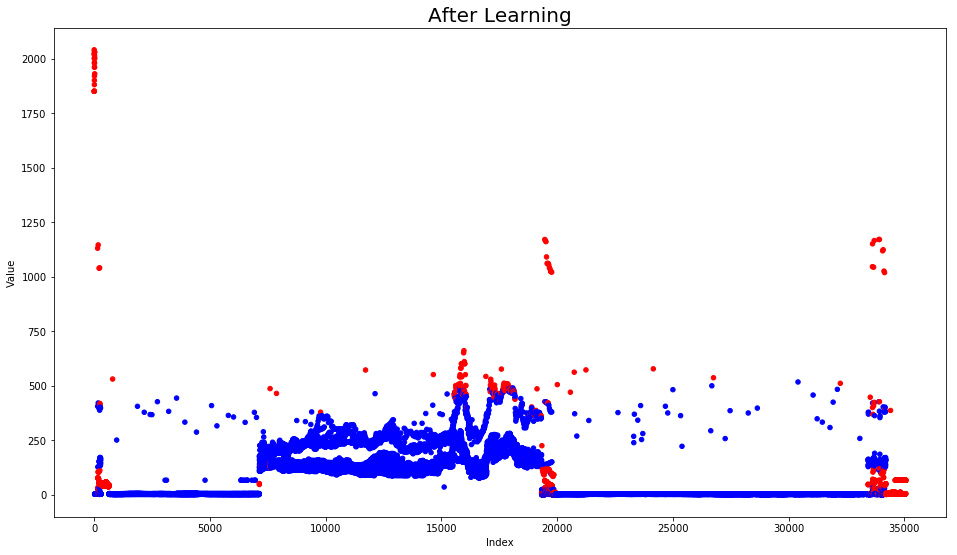

In [141]:
%matplotlib inline
import matplotlib.pyplot as plt
use_colours = {0: "blue", 1: "red"}
#ax.scatter(a,b,c,c=[use_colours[x[0]] for x in df["Outlier"]],s=50)

plt.figure(figsize=(16,9))
plt.scatter(df.index, df['price'], c=[use_colours[x] for x in df["Outlier_MAD"]], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

In [142]:
accuracy_MAD = 0
precision_MAD = 0
accuracy_PER = 0
precision_PER = 0
accuracy_RT = 0
precision_RT = 0

for i in range(len(df)):
    if df.loc[i,"Actual"] == df.loc[i,"Outlier_MAD"]:
        accuracy_MAD = accuracy_MAD + 1
    if df.loc[i,"Actual"] == df.loc[i,"Outlier_MAD"] == True:
        precision_MAD = precision_MAD + 1
    if df.loc[i,"Actual"] == df.loc[i,"Outlier_PER"]:
        accuracy_PER = accuracy_PER + 1
    if df.loc[i,"Actual"] == df.loc[i,"Outlier_PER"] == True:
        precision_PER = precision_PER + 1
    if df.loc[i,"Actual"] == df.loc[i,"Outlier_RT"]:
        accuracy_RT = accuracy_RT + 1
    if df.loc[i,"Actual"] == df.loc[i,"Outlier_RT"] == True:
        precision_RT = precision_RT + 1


In [143]:
accuracy = float(accuracy_MAD)/len(df)
precision_result = float(precision_MAD)/len(df[df.Actual==True])
print("Accuracy of MAD based Outlier detection using Autoencoders is :",accuracy)
print("Precision of MAD based Outlier detection using Autoencoders is :",precision_result)

('Accuracy of MAD based Outlier detection using Autoencoders is :', 0.9443525385054193)
('Precision of MAD based Outlier detection using Autoencoders is :', 0.19)


In [144]:
accuracy = float(accuracy_PER)/len(df)
precision_result = float(precision_PER)/len(df[df.Actual==True])
print("Accuracy of PER based Outlier detection using Autoencoders is :",accuracy)
print("Precision of PER based Outlier detection using Autoencoders is :",precision_result)

('Accuracy of PER based Outlier detection using Autoencoders is :', 0.9881346263548203)
('Precision of PER based Outlier detection using Autoencoders is :', 0.18)


In [145]:
accuracy = float(accuracy_RT)/len(df)
precision_result = float(precision_RT)/len(df[df.Actual==True])
print("Accuracy of RT based Outlier detection using Autoencoders is :",accuracy)
print("Precision of RT based Outlier detection using Autoencoders is :",precision_result)

('Accuracy of RT based Outlier detection using Autoencoders is :', 0.9967769537934968)
('Precision of RT based Outlier detection using Autoencoders is :', 0.0)


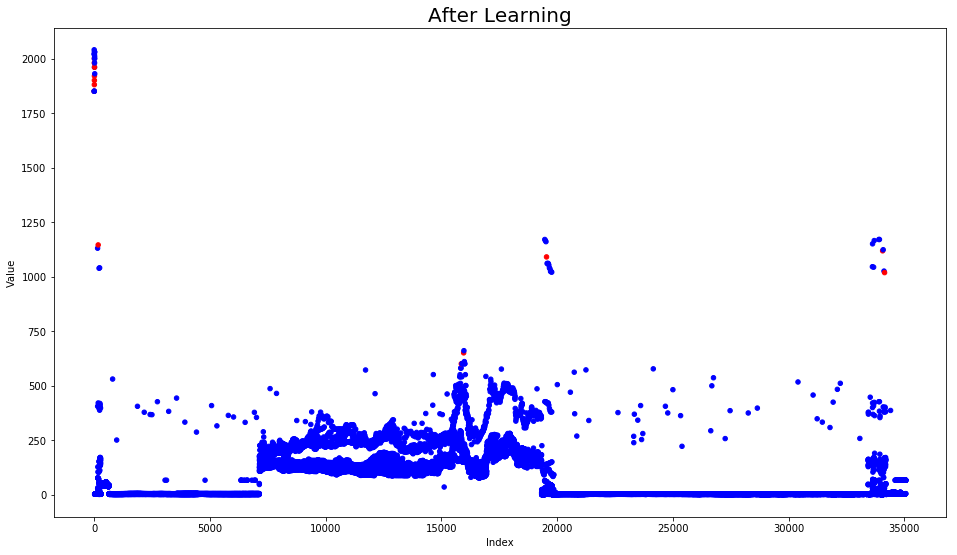

In [146]:
use_colours = {0: "blue", 1: "red"}
#ax.scatter(a,b,c,c=[use_colours[x[0]] for x in df["Outlier"]],s=50)

plt.figure(figsize=(16,9))
plt.scatter(df.index, df['price'], c=[use_colours[x] for x in df["Outlier_RT"]], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

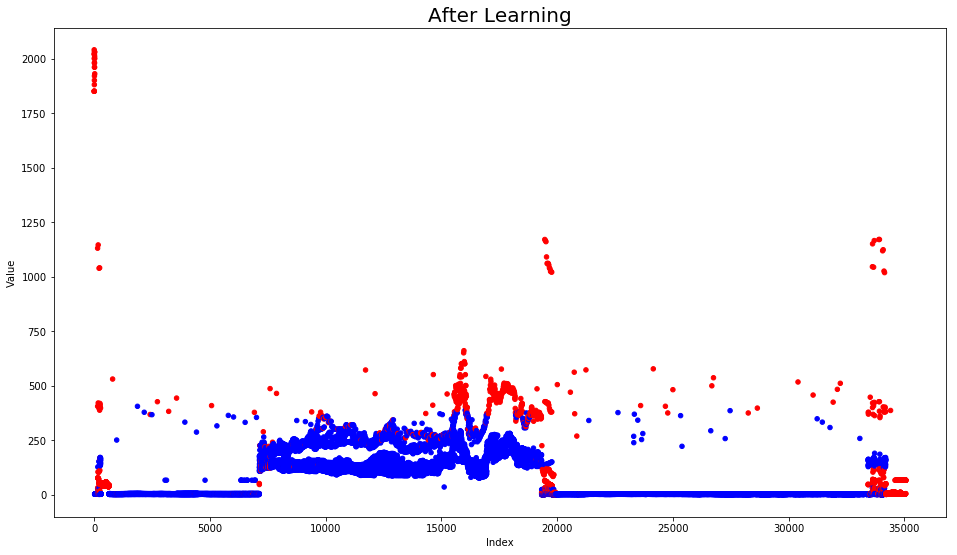

In [147]:
use_colours = {0: "blue", 1: "red"}
#ax.scatter(a,b,c,c=[use_colours[x[0]] for x in df["Outlier"]],s=50)
df["Outlier"] = df.apply(lambda x: 1 if abs(x['dist']) > 0.2 else 0, axis=1)
plt.figure(figsize=(16,9))
plt.scatter(df.index, df['price'], c=[use_colours[x] for x in df["Outlier"]], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

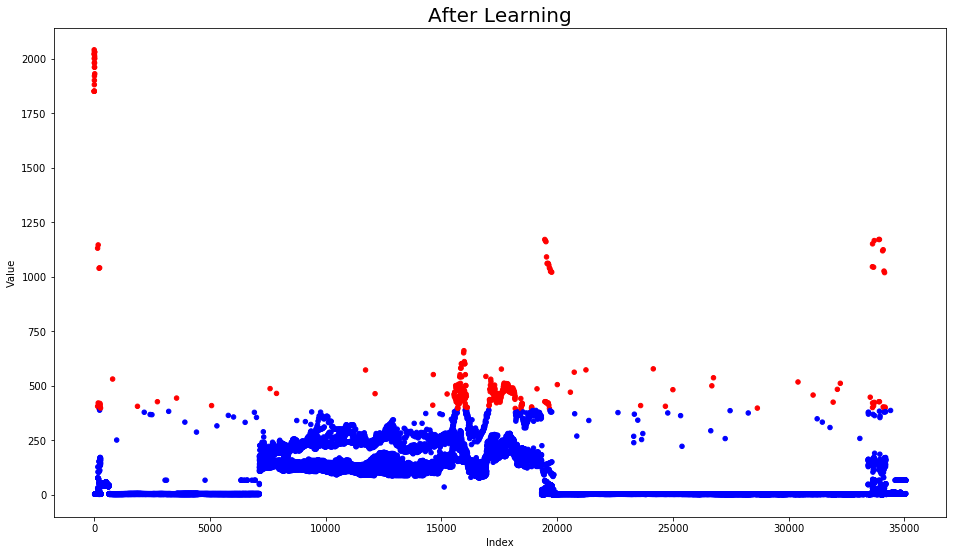

In [50]:

use_colours = {0: "blue", 1: "red"}
#ax.scatter(a,b,c,c=[use_colours[x[0]] for x in df["Outlier"]],s=50)

plt.figure(figsize=(16,9))
plt.scatter(df.index, df['price'], c=[use_colours[x] for x in df["Outlier_MR_1"]], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

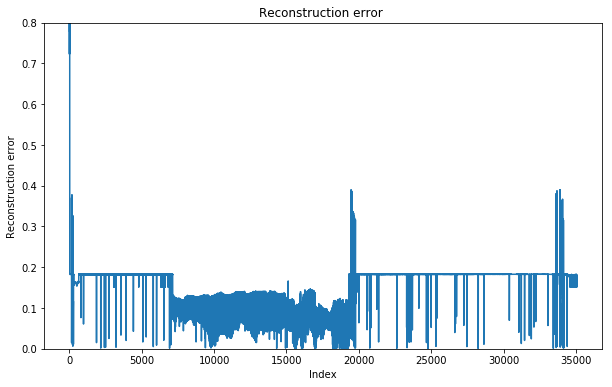

In [51]:
plt.figure(figsize=(10,6))
plt.plot(dist)
#plt.xlim((0,100))
plt.ylim((0,0.8))
plt.xlabel('Index')
plt.ylabel('Reconstruction error')
plt.title("Reconstruction error ")

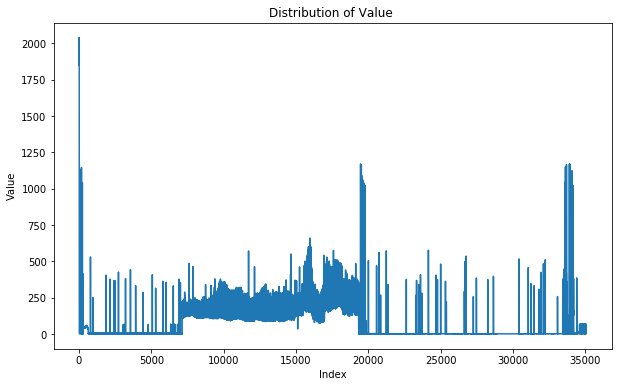

In [52]:
value = np.array(df["price"])
plt.figure(figsize=(10,6))
plt.plot(value)

#plt.xlim((0,1000))
#plt.ylim((0,0.8))
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("Distribution of Value ")

In [53]:
df = pd.read_csv("fact_price_weekly_multi.csv")

In [54]:
df["product"] = df["product"].astype('category').cat.codes
df["unit"] = df["unit"].astype('category').cat.codes
df["geo"] = df["geo"].astype('category').cat.codes

In [55]:
df.price = df.price.fillna(np.mean(df.price))

In [56]:
df[['Year']] = df[['date_sk']].applymap(str).applymap(lambda s: "{}".format(s[0:4]))
df[['Month']] = df[['date_sk']].applymap(str).applymap(lambda s: "{}".format(s[4:6]))
df[['Day']] = df[['date_sk']].applymap(str).applymap(lambda s: "{}".format(s[6:8]))

df.head()

,id,date_sk,geo,unit,product,price,source,Year,Month,Day
0,253138,20161130,16,16,18,1850.0,clal_dutch_smp_price_weekly,2016,11,30
1,253137,20161130,16,16,19,2040.0,clal_dutch_smp_price_weekly,2016,11,30
2,253136,20161123,16,16,18,1850.0,clal_dutch_smp_price_weekly,2016,11,23
3,253135,20161123,16,16,19,2020.0,clal_dutch_smp_price_weekly,2016,11,23
4,253134,20161116,16,16,18,1850.0,clal_dutch_smp_price_weekly,2016,11,16


In [57]:
y = df["price"]
X = df[["geo","unit","product","Year","Month","Day"]]

In [58]:
X.head()

,geo,unit,product,Year,Month,Day
0,16,16,18,2016,11,30
1,16,16,19,2016,11,30
2,16,16,18,2016,11,23
3,16,16,19,2016,11,23
4,16,16,18,2016,11,16


In [59]:
# Recursive Feature Elimination
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
# load the iris datasets
#dataset = datasets.load_iris()
# create a base classifier used to evaluate a subset of attributes
model = LinearRegression()
# create the RFE model and select 3 attributes
rfe = RFE(model, 3)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[False  True False  True  True False]
[2 1 3 1 1 4]


In [60]:
X = X[["geo","Year","Month"]]

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [63]:

X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.fit_transform(X_test)
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.fit_transform(y_test)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

In [64]:
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [65]:
pred = model.predict(X_test)

In [66]:
from sklearn.metrics import r2_score  
from sklearn.metrics import mean_squared_error
mean_sqr = mean_squared_error(y_test,pred)
score = r2_score(y_test,pred)

In [67]:
print(score)

0.0412118178533


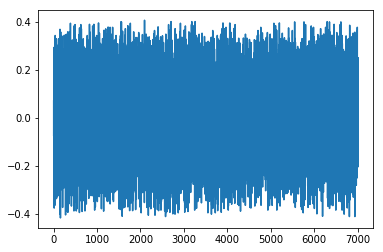

In [68]:
plt.plot(pred)

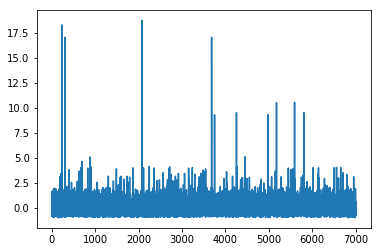

In [69]:
detrended = [y_test[j]-pred[j] for j in range(0, len(pred))]
plt.plot(detrended)

In [70]:
"""

def outlierCleaner(predictions, X_train, y_train):
    
        Clean away the 10% of points that have the largest
        residual errors (difference between the prediction
        and the actual net worth).
        Return a list of tuples named cleaned_data where 
        each tuple is of the form (age, net_worth, error).
    
    
    error = list( (y_train - predictions)**2 )

    cleaned_data = zip(X_train, y_train, error)
    cleaned_data = sorted(cleaned_data, key = lambda tup: tup[2])
    result = int(len(cleaned_data)*0.95)
    cleaned = cleaned_data[:result]
    anomalies = cleaned_data[result:]

    ### your code goes here

    
    return cleaned,anomalies
"""

'\n\ndef outlierCleaner(predictions, X_train, y_train):\n    \n        Clean away the 10% of points that have the largest\n        residual errors (difference between the prediction\n        and the actual net worth).\n        Return a list of tuples named cleaned_data where \n        each tuple is of the form (age, net_worth, error).\n    \n    \n    error = list( (y_train - predictions)**2 )\n\n    cleaned_data = zip(X_train, y_train, error)\n    cleaned_data = sorted(cleaned_data, key = lambda tup: tup[2])\n    result = int(len(cleaned_data)*0.95)\n    cleaned = cleaned_data[:result]\n    anomalies = cleaned_data[result:]\n\n    ### your code goes here\n\n    \n    return cleaned,anomalies\n'

In [97]:
from sklearn.ensemble import IsolationForest
df = pd.read_csv("fact_price_weekly_multi.csv")
df.price = df.price.fillna(np.mean(df.price))
df["Actual"] = False
np.random.seed(1)
df = df.reset_index()
df.columns.values[0] = "Sno"
df.columns
df_new = df[['Sno','price']]
#X = np.array(df_new)

X_train,X_test = train_test_split(df_new,test_size=0.2)
X_test = X_test.reset_index(drop=True)
X_test["Actual"] = False
for i in Outliers:
    loc = np.random.randint(0, len(X_test))
    #print(X_test.loc[loc,"price"])
    X_test.loc[loc,"price"] = i
    #print(X_test.loc[loc,"price"])
    X_test.loc[loc,"Actual"] = True
    #print(X_test.loc[loc,"Actual"])
X_test_sub = X_test[['Sno','price']]
#print(X_test)
# fit the model
clf = IsolationForest(max_samples="auto",n_estimators=100,bootstrap=True,contamination=0.01,)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test_sub)

In [98]:
y_pred_test[y_pred_test ==1] = False
y_pred_test[y_pred_test ==-1] = True


In [99]:
from sklearn.metrics import confusion_matrix,roc_curve,auc,cohen_kappa_score
cm=confusion_matrix(X_test.Actual,y_pred_test)

In [100]:
cm

array([[6838,   74],
       [  38,   62]])

In [101]:
coh = cohen_kappa_score(X_test.Actual,y_pred_test)
print(coh)

0.517492897657


In [102]:
print(classification_report(X_test.Actual,y_pred_test))

             precision    recall  f1-score   support

      False       0.99      0.99      0.99      6912
       True       0.46      0.62      0.53       100

avg / total       0.99      0.98      0.99      7012



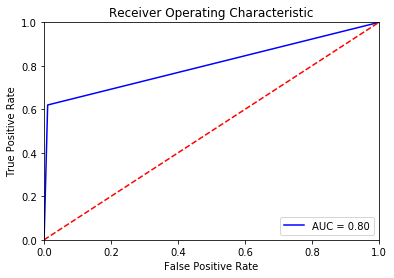

In [103]:
fpr, tpr, threshold = roc_curve(X_test.Actual,y_pred_test)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [104]:
accuracy_count = 0
precision_count = 0


for i in range(len(X_test)):
    if X_test.loc[i,"Actual"] == y_pred_test[i]:
        accuracy_count = accuracy_count + 1
    if X_test.loc[i,"Actual"] == y_pred_test[i] == True:
        precision_count = precision_count + 1
   

In [105]:
accuracy = float(accuracy_count)/len(X_test_sub)

precision_result = float(precision_count)/len(X_test_sub[X_test.Actual==True])
print("Accuracy of Iforest based Outlier detection using Autoencoders is :",accuracy)
print("Precision of Iforest based Outlier detection using Autoencoders is :",precision_result)

('Accuracy of Iforest based Outlier detection using Autoencoders is :', 0.9840273816314888)
('Precision of Iforest based Outlier detection using Autoencoders is :', 0.62)


In [106]:
X_test_sub.reset_index()
X_test_sub = X_test_sub.reset_index()
X_test_sub = X_test_sub.reset_index()
X_test_sub.columns.values[0] = "new_index"
X_test_sub["Actual"] = X_test["Actual"]

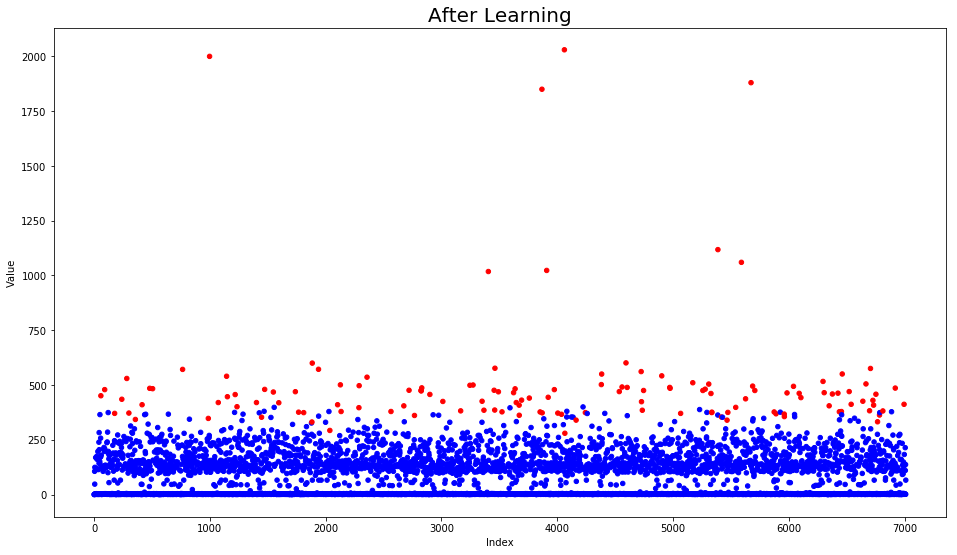

In [107]:
%matplotlib inline
import matplotlib.pyplot as plt
use_colours = {1: "red", 0: "blue"}
#ax.scatter(a,b,c,c=[use_colours[x[0]] for x in df["Outlier"]],s=50)

plt.figure(figsize=(16,9))
plt.scatter(X_test.index, X_test["price"], c=[use_colours[x] for x in y_pred_test], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")